In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
last_record=session.query(measurement).order_by(measurement.date.desc()).first().date
year_ago_date=dt.datetime.strptime(last_record,'%Y-%m-%d') - dt.timedelta(days=365)
scores=session.query(measurement.date, measurement.prcp).\
    filter(measurement.date>=year_ago_date).all()

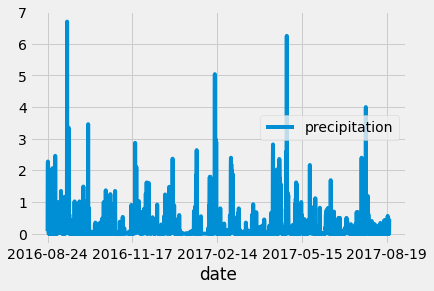

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp = pd.DataFrame(scores, columns=['date', 'precipitation'])
prcp=prcp.set_index("date",inplace=False)
# Sort the dataframe by date
prcp=prcp.sort_index(ascending=True)
prcp=prcp.dropna()
# Use Pandas Plotting with Matplotlib to plot the data
ax =prcp.plot().get_figure()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(station).count()
station_count

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active_station=session.query(measurement.station,station.name,func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()
print(f"The most active station is {most_active_station.name}")
station_activity

The most active station is WAIKIKI 717.2, HI US


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_data=session.query(func.min(measurement.tobs), 
       func.max(measurement.tobs), 
       func.avg(measurement.tobs)).\
    filter(measurement.station=="USC00519281").all()
most_active_station_data

[(54.0, 85.0, 71.66378066378067)]

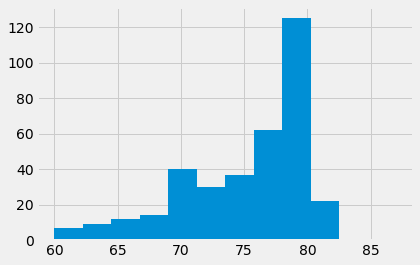

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp_station=session.query(measurement.station,func.max(measurement.tobs)).first()
highest_temp_station_data=session.query(measurement.date, measurement.tobs).\
    filter(measurement.date>=year_ago_date).\
    filter(measurement.station==highest_temp_station.station).all()
ht_station_df = pd.DataFrame(highest_temp_station_data, columns=['date', 'Tobs'])
ht_station_df=ht_station_df.set_index('date',inplace=False)
ht_station_df=ht_station_df.dropna()
# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(ht_station_df['Tobs'],12, label="tobs")
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start=dt.date(2012,2,28)
trip_end=dt.date(2012,3,5)
previous_year=dt.timedelta(days=365)
trip_data=calc_temps((trip_start-previous_year),(trip_end-previous_year))
trip_data

[(61.0, 70.08928571428571, 75.0)]

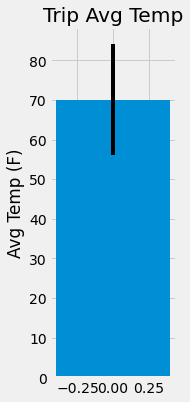

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df=pd.DataFrame(data=trip_data, columns=["tmin", "tavg", "tmax"])
peak_to_peak = trip_df['tmax'] - trip_df['tmin']
plt.figure(figsize=[2, 6])
x=trip_df.index.values
y=trip_df['tavg']
pavg = plt.bar(x, y, yerr=peak_to_peak)
plt.ylabel('Avg Temp (F)')
plt.title('Trip Avg Temp')
plt.show()

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_previous=trip_start-previous_year
end_previous=trip_end-previous_year
data= session.query(station.station,func.sum(measurement.prcp),station.name,
                    station.latitude,station.longitude,station.elevation).\
                    filter(measurement.station == station.station).\
                    filter(measurement.date >= start_previous).\
                    filter(measurement.date <= end_previous).\
                    group_by(station.station).\
                    order_by(func.sum(measurement.prcp).desc())
data_df=pd.DataFrame(data=data,columns=["station","sum","station name","lat","lng","elevation"])
data_df

,station,sum,station name,lat,lng,elevation
0,USC00519281,3.74,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00514830,2.60,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00513117,2.60,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,2.46,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00518838,2.33,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00516128,1.69,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
6,USC00519397,1.41,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
7,USC00511918,0.63,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [39]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [40]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
trip=pd.date_range(trip_start,trip_end)
# Stip off the year and save a list of %m-%d strings
trip_format=trip.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for trip in trip_format:
    # call daily_normals function to return the tuple list
    normals.append(*daily_normals(trip))
normals

[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [41]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df=pd.DataFrame(data=normals,columns=["tmin","tavg","tmax"])
daily_normals_df["date"]=trip
daily_normals_df=daily_normals_df.set_index("date")
daily_normals_df

,tmin,tavg,tmax
date,,,
03-05,65.0,70.655172,80.0
03-05,67.0,71.733333,79.0
03-05,64.0,70.032787,76.0
03-05,61.0,70.366667,78.0
03-05,60.0,70.068966,78.0
03-05,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


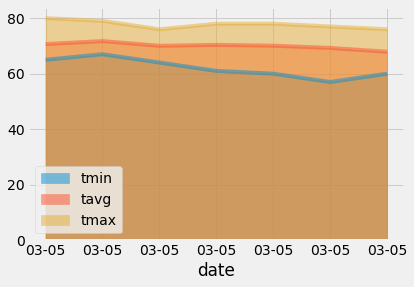

In [42]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_normals_df.plot.area(stacked=False)